# Exploring unimodal data

This tutorial demonstrates a new approach for analyzing unimodal developmental single-cell data using Ocelli. The proposed workflow uses topic modeling for finding cohesive regions (topics) in the single-cell expression space. We treat each topic as a separate modality, which consists of features that are highly specific to this topic. Using topic-based modalities significantly reduces noise in the single-cell data.

## Pancreatic endocrinogenesis (RNA-seq)

This RNA-seq dataset consists of pancreatic developmental cells sampled from embryonic day 15.5. Endocrine cells are derived from endocrine progenitors and form four significant lineages:

- Glucagon-producing Alpha cells,
- Insulin-producing Beta cells,
- Somatostatin-producing Delta cells,
- Ghrelin-producing Epsilon cells.

Data comes from [Bastidas-Ponce, Aimée, et al. "Comprehensive single cell mRNA profiling reveals a detailed roadmap for pancreatic endocrinogenesis." Development 146.12 (2019): dev173849.](https://journals.biologists.com/dev/article/146/12/dev173849/19483/Comprehensive-single-cell-mRNA-profiling-reveals-a). It can be downloaded from [scVelo](https://scvelo.readthedocs.io/scvelo.datasets.pancreas/).

Import necessary packages.

In [1]:
import ocelli as oci
import scanpy as sc
import scvelo as scv

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

SEED = 17

### Load and preprocess the data

Load the data using scVelo.

In [2]:
adata = scv.datasets.pancreas()

adata

AnnData object with n_obs × n_vars = 3696 × 27998
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score'
    var: 'highly_variable_genes'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'neighbors', 'pca'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'
    obsp: 'distances', 'connectivities'

In [3]:
adata.write('pancreas-raw.h5ad', compression='gzip', compression_opts=9)

Filter out low-expressed genes and low-quality cells.

In [3]:
scv.pp.filter_genes(adata, min_shared_cells=20)

Filtered out 22533 genes that are detected in less than 20 cells (shared).


As with the previous tutorials, the first step is the LDA topic modeling.

In [ ]:
oci.pp.LDA(adata, n_components=20, verbose=1, max_iter=50, random_state=SEED)

Training the MDM on the LDA-reduced RNA-seq count matrix would result in normal, unimodal Diffusion Maps. While such an approach is perfectly valid, LDA provides additional information - variational parameters for gene-topic distribution. These parameters can be interpreted as a pseudo count representing the number of times a gene was assigned to a topic. ``oci.pp.LDA`` saves these parameters to ``adata.varm['lda']`` as an array of shape ``(n_var, n_topics)``.

In [ ]:
adata.varm['lda'].shape

Topic modeling learns cohesive groups of genes. We propose to treat them as individual modalities. ``oci.pp.modality_generation`` looks at variational parameters in ``adata.varm['lda']`` and assigns each gene to a highest-parameter topic. Grouped genes form new modalities. Note that generated modalities are not in the LDA latent space but in the single-cell expression space. You can control the number of genes in each modality - the default value is at most 100. If you set ``norm_log`` to True, new modalities are normalized and logarithmized.

In [ ]:
oci.pp.modality_generation(adata, lda_weights_key='lda_weights', n_top_vars=100, norm_log=True, verbose=True)

In [ ]:
adata.uns['vars_4']

``oci.pp.modality_generation`` automatically saves generated modality names to ``adata.uns['modalities']``.

In [ ]:
adata.uns['modalities']

We suggest visualizing this dataset with additional RNA velocity information for the better reconstruction of developmental fates. Data downloaded from scVelo includes unspliced and spliced gene expression layers ready for RNA velocity estimation.

Calculate velocities on normalized and logarithmized highly variable genes. 

In [ ]:
scv.pp.normalize_per_cell(adata, counts_per_cell_after=10000)
scv.pp.filter_genes_dispersion(adata, n_top_genes=1000)
scv.pp.log1p(adata)

scv.tl.velocity(adata, mode='stochastic')
scv.tl.velocity_graph(adata)

### Multimodal Diffusion Maps

Modalities with normalized and logarithmized topic-specific gene counts are ready for the MDM training. We use LDA's cell-topic distributions as weights. These distributions can be interpreted as the assignment of topics to cells. In other words, a cell's MDM representation is based only on genes specific to topics assigned to a cell. The significant advantage of such an approach is that for each expression space region (topic), you utilize only relevant region-specific (topic-specific) genes. This step significantly reduces noise existing in single-cell data.

``oci.pp.modality_generation`` saves LDA-based weights to ``adata.obsm['lda_weights']``.

In [ ]:
adata.obsm['lda_weights']

Calculate the MDM representation.

In [ ]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda_weights', n_components=25, random_state=SEED, verbose=True)

Calculate the ForceAtlas2 representation of the MDM embedding's RNA velocity-based graph.

In [ ]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.velocity_graph(adata, n_edges=20, neighbors_key='X_mdm', verbose=True)

oci.tl.FA2(adata, n_components=2, random_state=SEED, output_key='X_fa2')

In [17]:
adata.write('pancreas-results.h5ad', compression='gzip', compression_opts=9)

In [2]:
import anndata as ad
adata = ad.read_h5ad('pancreas-results.h5ad')

In [3]:
cdict = {'Ductal': '#cb111e',
         'Ngn3 low EP': '#814eaf', 
         'Ngn3 high EP': '#fc8384',
         'Pre-endocrine': '#1a62a5',
         'Alpha': '#a0bae2', 
         'Beta': '#289322', 
         'Epsilon': '#89db77', 
         'Delta': '#fdac65'}

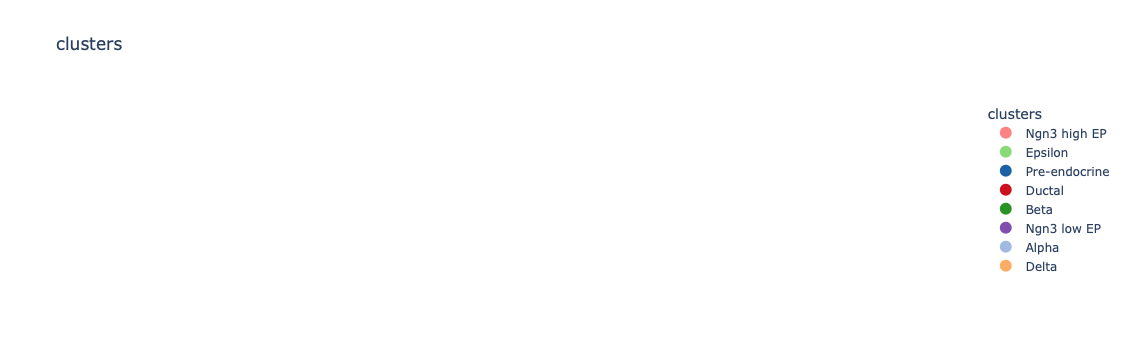

In [4]:
oci.pl.scatter_interactive(adata, x='X_fa2', c='clusters', markersize=2, cdiscrete=cdict)

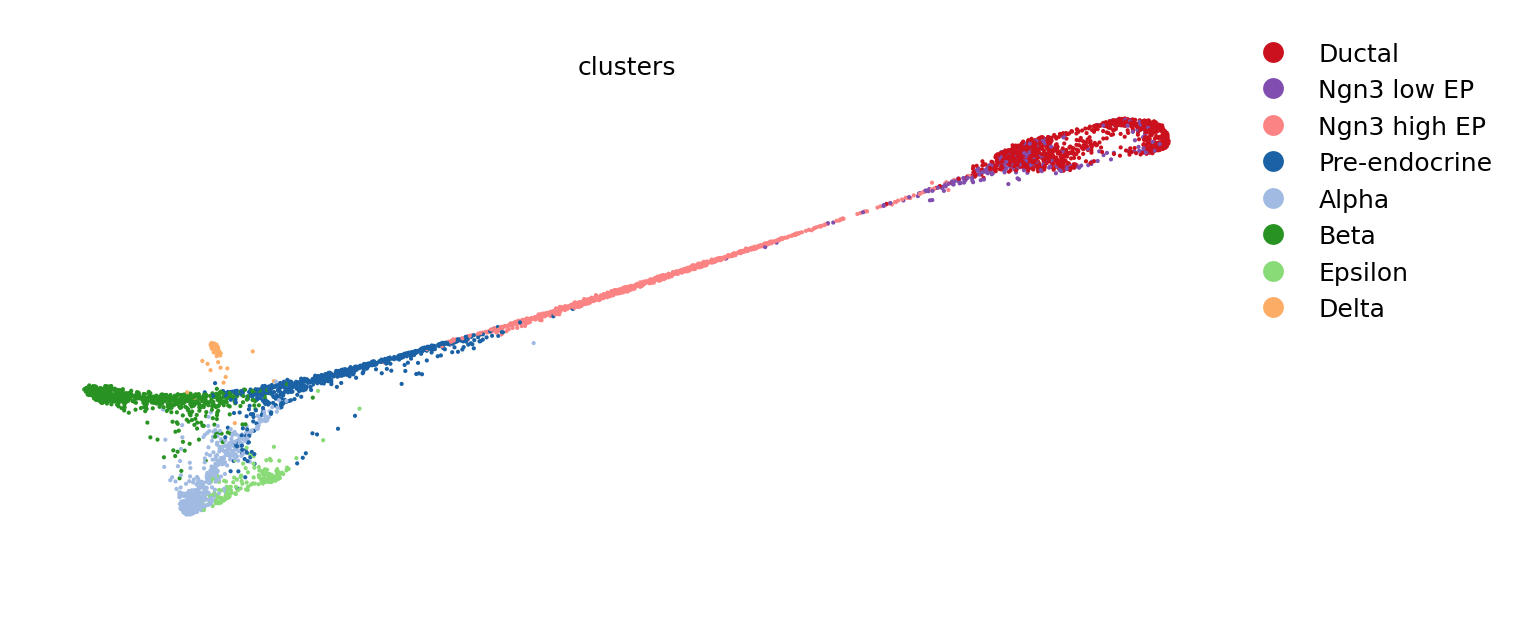

In [5]:
oci.pl.scatter(adata, x='X_fa2', c='clusters', cdict=cdict, markersize=1, figsize=(5, 2))

665     D
2607    D
231     D
2671    C
3062    C
       ..
415     D
2996    C
2360    D
3374    B
1014    D
Name: 0, Length: 3696, dtype: object
0 False
665     B
2607    C
231     D
2671    D
3062    A
       ..
415     B
2996    B
2360    C
3374    B
1014    B
Name: 1, Length: 3696, dtype: object
1 False
665     B
2607    D
231     B
2671    B
3062    D
       ..
415     D
2996    D
2360    A
3374    D
1014    A
Name: 2, Length: 3696, dtype: object
2 False
665     C
2607    B
231     C
2671    B
3062    D
       ..
415     A
2996    B
2360    A
3374    A
1014    C
Name: 3, Length: 3696, dtype: object
3 False
665     A
2607    C
231     D
2671    A
3062    A
       ..
415     C
2996    B
2360    B
3374    A
1014    B
Name: 4, Length: 3696, dtype: object
4 False
665     C
2607    B
231     C
2671    A
3062    C
       ..
415     D
2996    A
2360    B
3374    D
1014    D
Name: 5, Length: 3696, dtype: object
5 False
665     B
2607    D
231     A
2671    A
3062    D
       ..
415     A


<Figure size 1500x600 with 0 Axes>

<Figure size 1500x600 with 0 Axes>

In [9]:
trial_d = {'A': 'black', 'B': 'green', 'C': 'blue', 'D': 'red'}

In [10]:
adata.obsm['trial'] = np.random.choice(['A', 'B', 'C', 'D'], size=(adata.shape[0], 7))

In [121]:
adata.obsm['trial']

array([['A', 'A', 'D', ..., 'C', 'B', 'B'],
       ['A', 'A', 'D', ..., 'A', 'C', 'D'],
       ['B', 'A', 'B', ..., 'D', 'A', 'D'],
       ...,
       ['A', 'A', 'D', ..., 'D', 'A', 'A'],
       ['A', 'C', 'A', ..., 'B', 'A', 'B'],
       ['A', 'A', 'D', ..., 'B', 'C', 'B']], dtype='<U1')

In [ ]:
cmap = mpl.colors.LinearSegmentedColormap.from_list('custom', ['#cb111e', '#814eaf', '#fc8384', '#1a62a5', '#a0bae2',
                                                               '#289322', '#89db77', '#fd6910', '#fdac65'], N=256)

Plot the 2D embedding with the annotations prepared by the dataset authors (stored in ``adata.obs['clusters']``). 

(<Figure size 1920x1440 with 1 Axes>, <AxesSubplot:>)

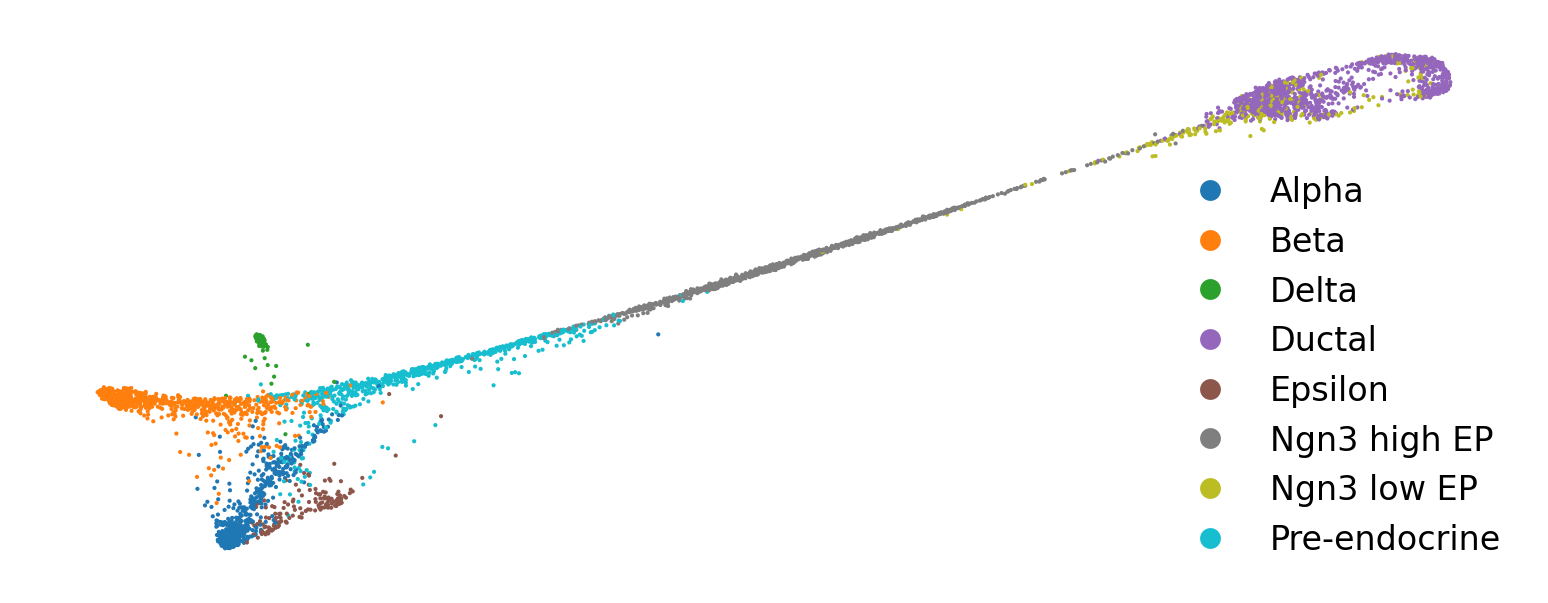

In [23]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='clusters', cmap='tab10', marker_size=1, fontsize=8)

Each LDA topic relates to a different region of the single-cell expression space. You can investigate these regions by plotting topic activity (cell-topic distributions).

(<Figure size 1920x1440 with 41 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>],
        [<AxesSubplot:title={'center':'3'}>,
         <AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>],
        [<AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>,
         <AxesSubplot:title={'center':'8'}>],
        [<AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>],
        [<AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>],
        [<AxesSubplot:title={'center':'15'}>,
         <AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>],
        [<AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>, <AxesSubplot:>]],
       dtype=object))

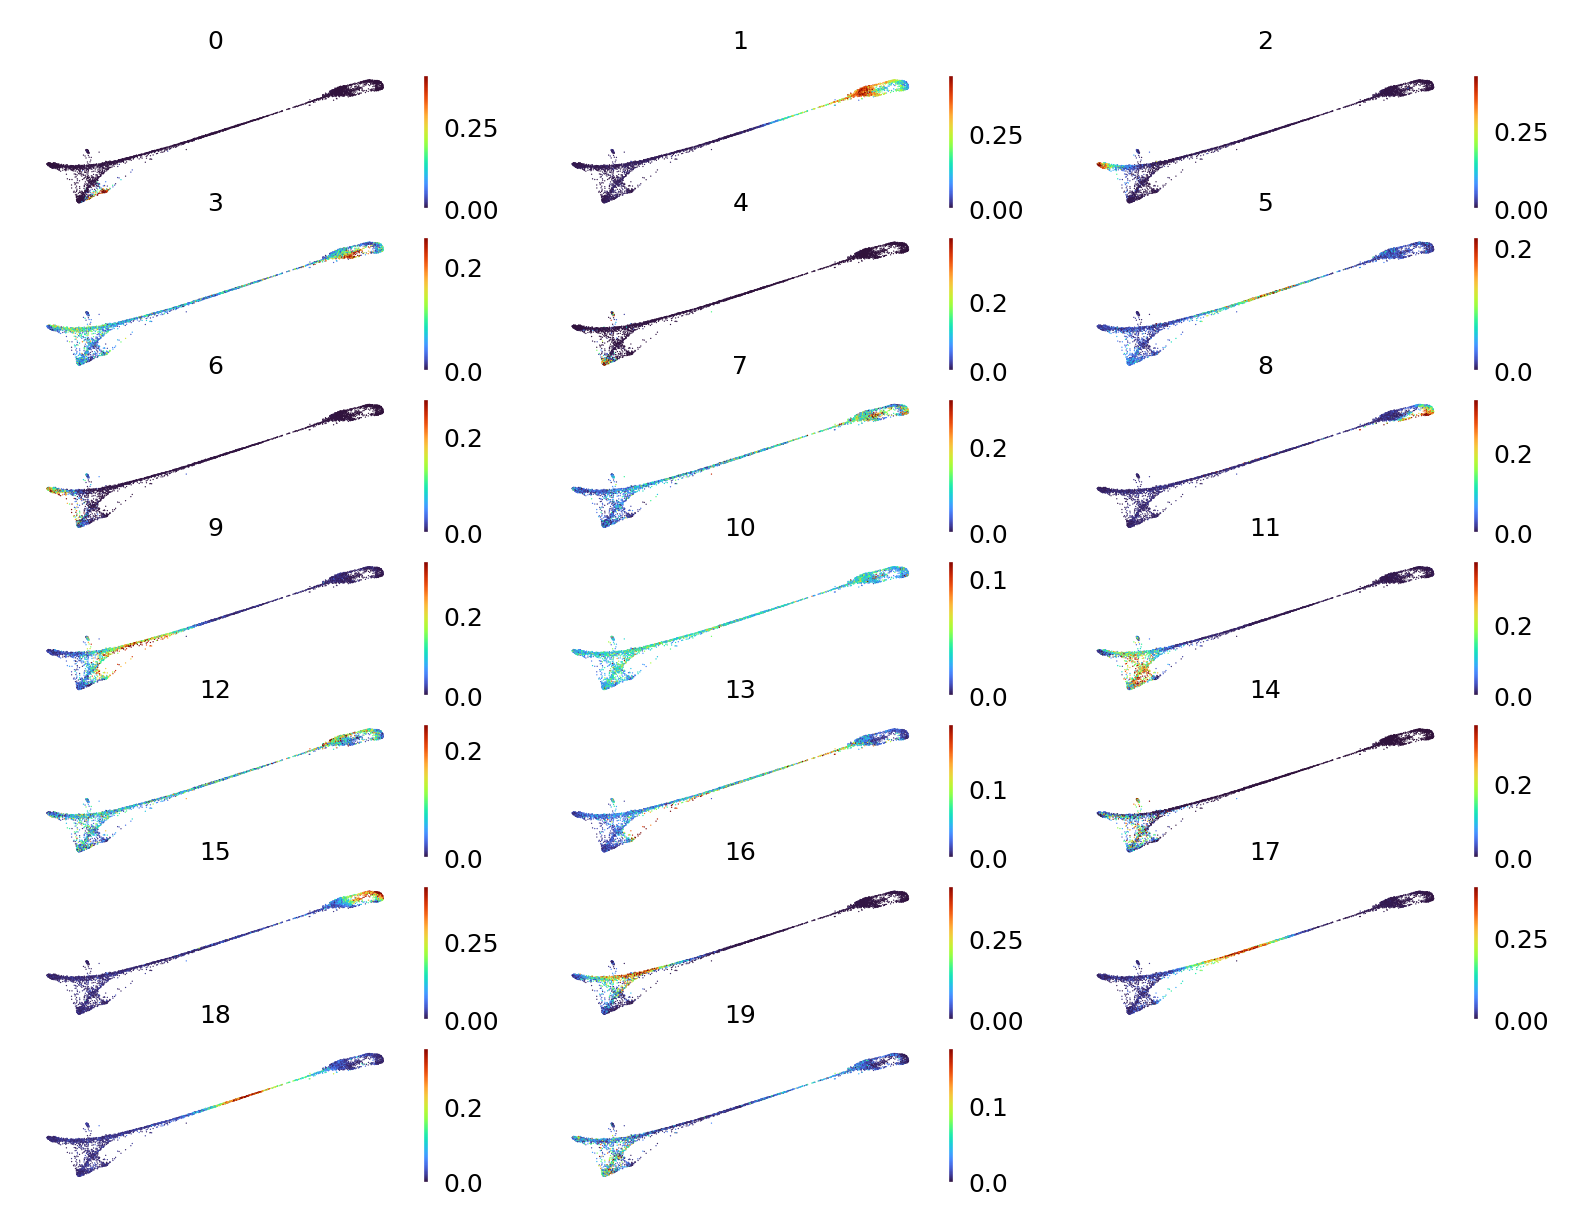

In [19]:
oci.pl.scatter(adata, x_key='X_fa2', color_key='lda', cmap='turbo', marker_size=0.1, vmin=0, max_columns=3)

Two significant regions split the developmental process: proliferative Ductal cells, and endocrine lineages.

### Cell cycle reconstruction

Firstly, investigate the cell cycle of proliferative Ductal cells.

computing velocity embedding
    finished (0:00:01) --> added
    'velocity_fa2', embedded velocity vectors (adata.obsm)


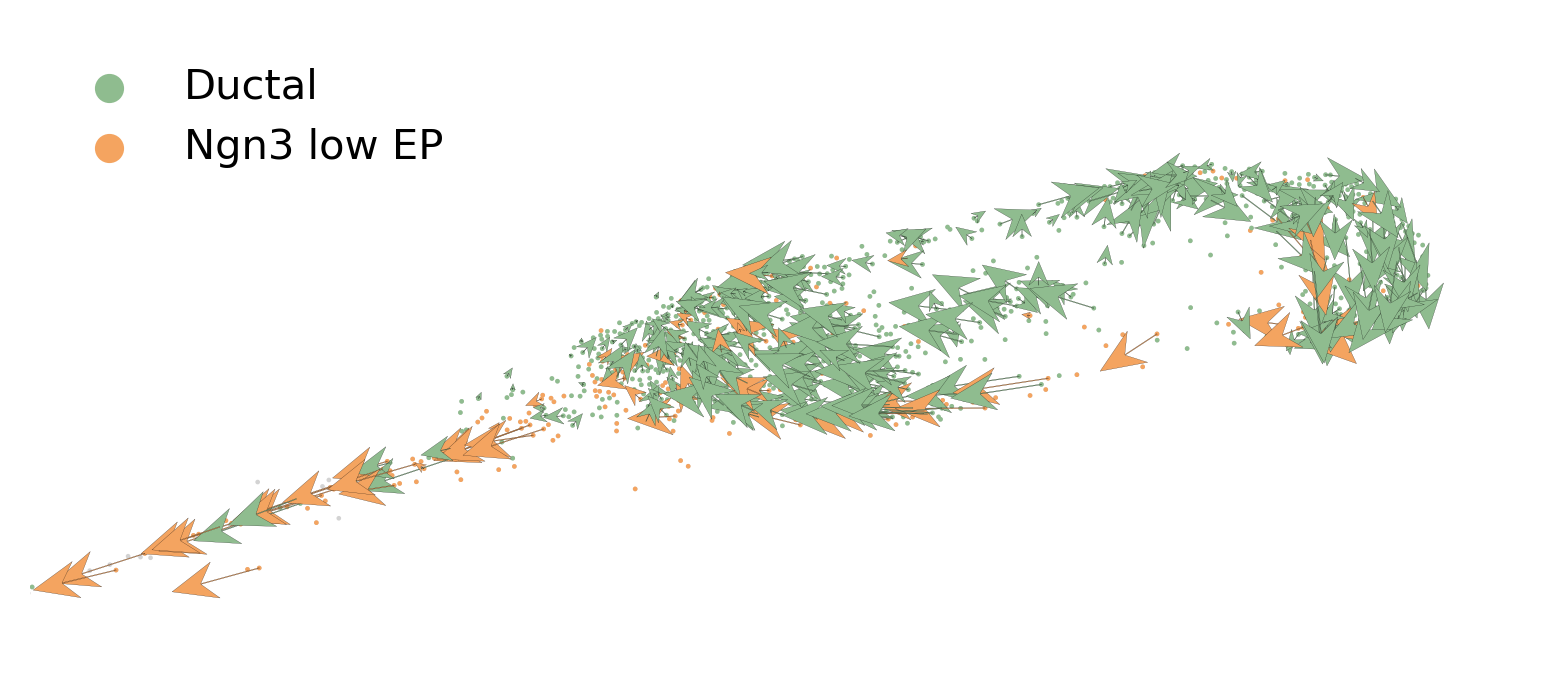

In [20]:
fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=5, alpha=1, 
                          title='', density=0.3, size=5, legend_loc='best',
                          linewidth=0.05, show=False, ax=ax, groups=['Ductal', 'Ngn3 low EP'],
                          xlim=[8000, 14000], ylim=[2500, 5000])
ax.set_aspect('equal')

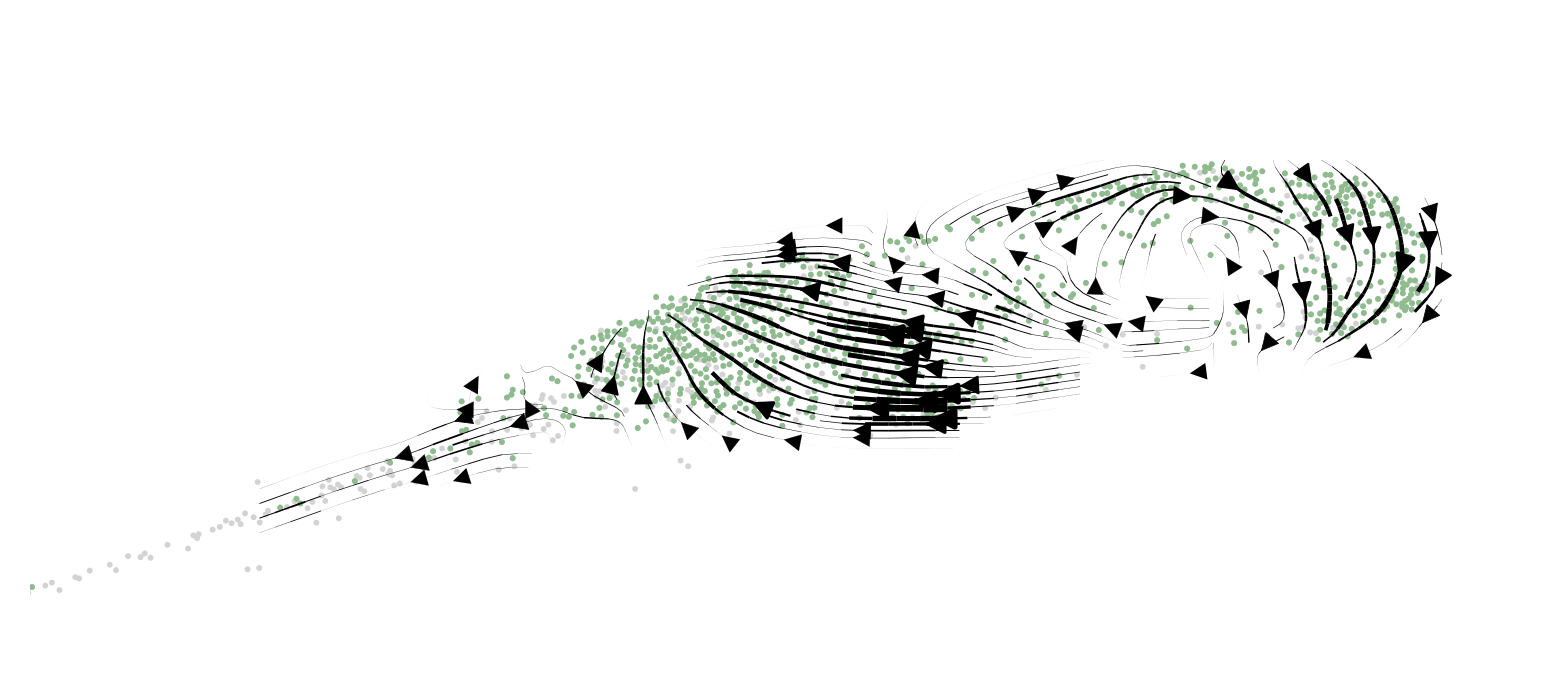

In [21]:
fig, ax = plt.subplots()

scv.pl.velocity_embedding_stream(adata, basis='fa2', alpha=1, title='', density=2, 
                                 linewidth=1, size=8, legend_loc='none', groups=['Ductal'], show=False, ax=ax,
                                 xlim=[8000, 14000], ylim=[2500, 5000])

ax.set_aspect('equal')

You can validate the velocity stream by plotting scores for:

- S (DNA replication) cell cycle phase,
- combined G2 (preparation for mitosis) and M (cell division) cell cycle phases.

Arrows should go from high S-scoring cells towards high G2M-scoring cells.

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


Text(0.5, 1.0, 'Combined G2 and M phases\nPreparation for mitosis and cell division')

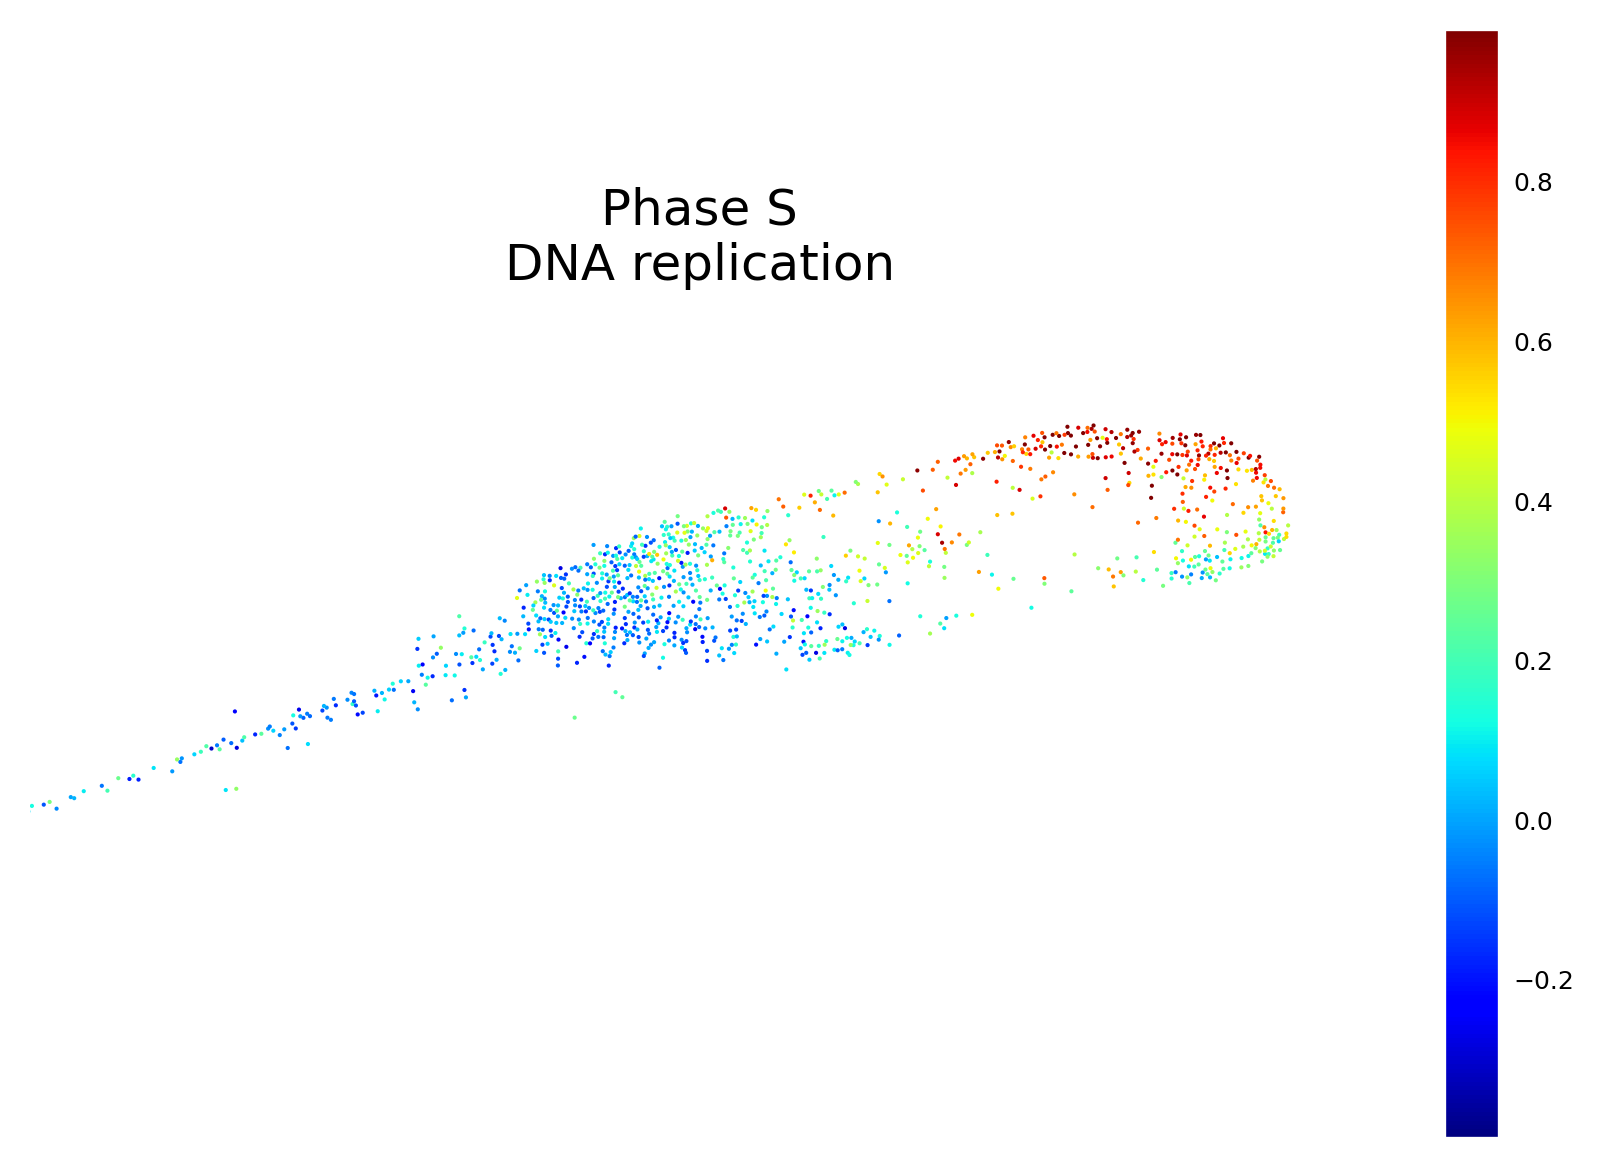

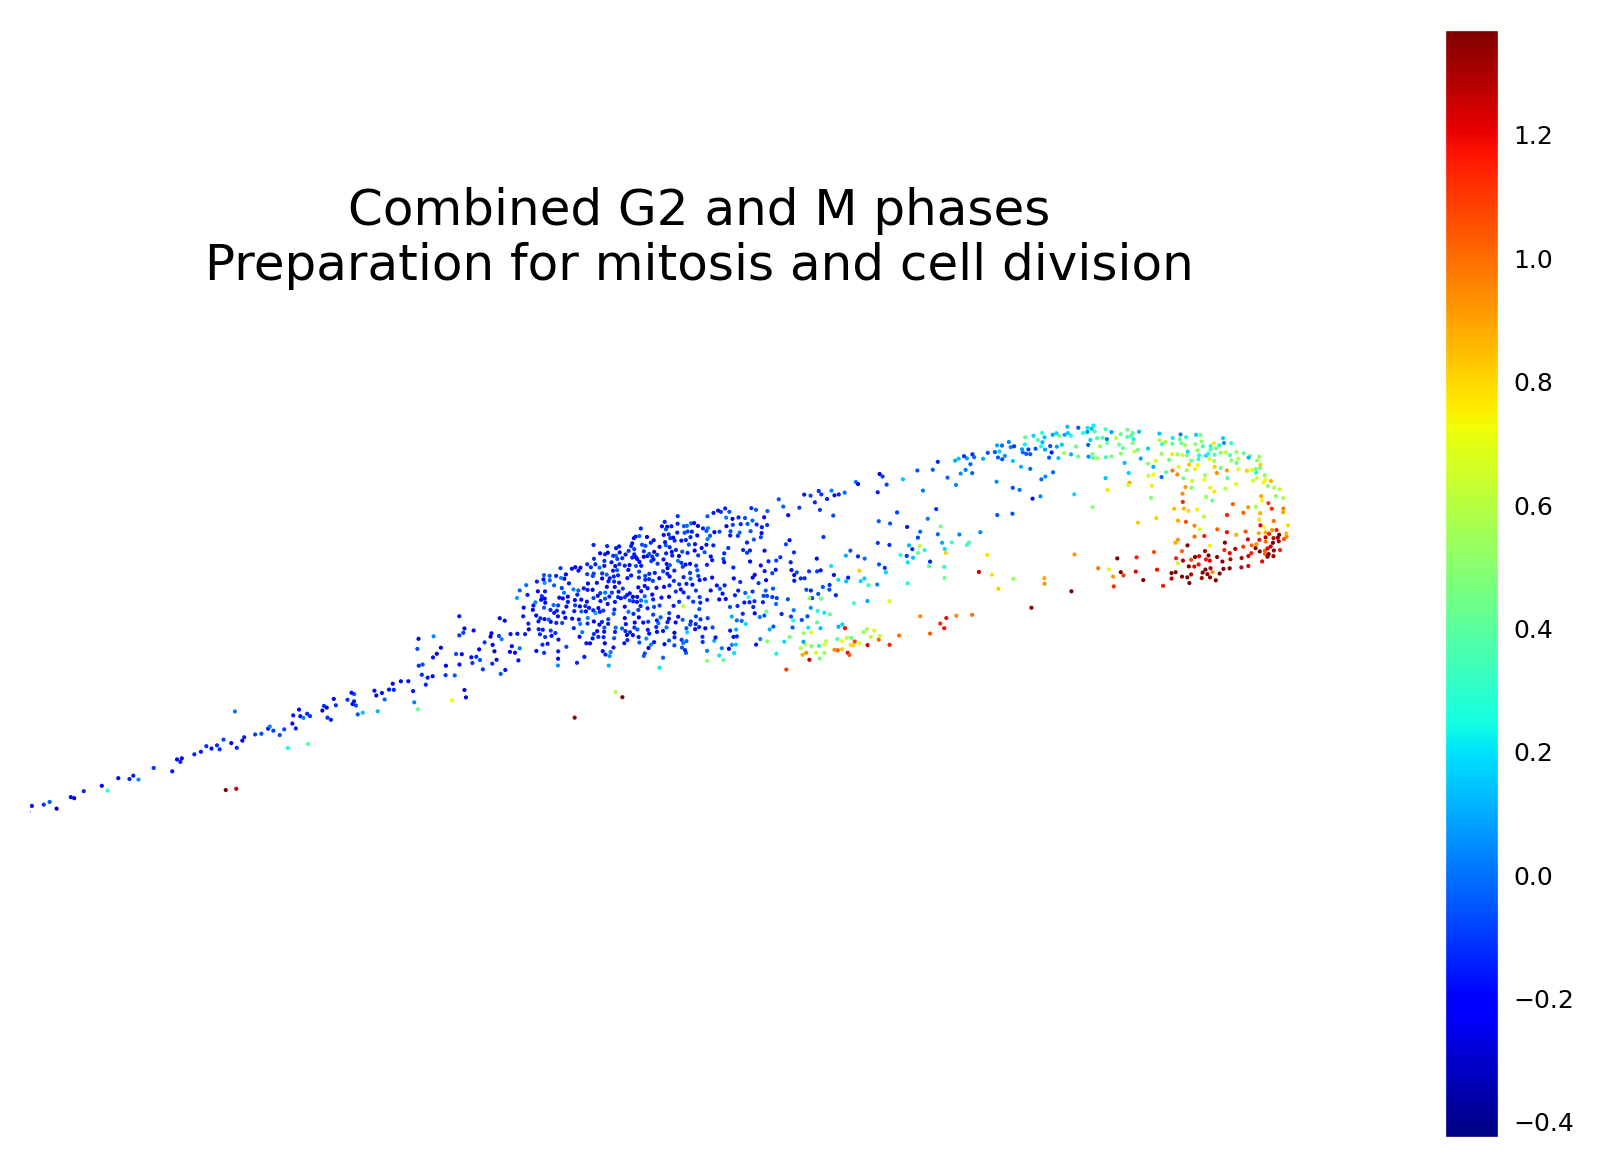

In [16]:
scv.tl.score_genes_cell_cycle(adata)

fig, ax = oci.pl.scatter(adata, x_key='X_fa2', color_key='S_score', cmap='jet', marker_size=1)
ax.set_xlim([8000, 14000])
ax.set_ylim([2500, 5000])
ax.set_title('Phase S\nDNA replication')


fig, ax = oci.pl.scatter(adata, x_key='X_fa2', color_key='G2M_score', cmap='jet', marker_size=1)
ax.set_xlim([8000, 14000])
ax.set_ylim([2500, 5000])
ax.set_title('Combined G2 and M phases\nPreparation for mitosis and cell division')

### Development of endocrine cells

The development of four endocrine fates: Alpha, Beta, Delta, and Epsilon was studied [here](https://www.nature.com/articles/s41422-021-00486-w). MDM manages to reconstruct all four lineages. 

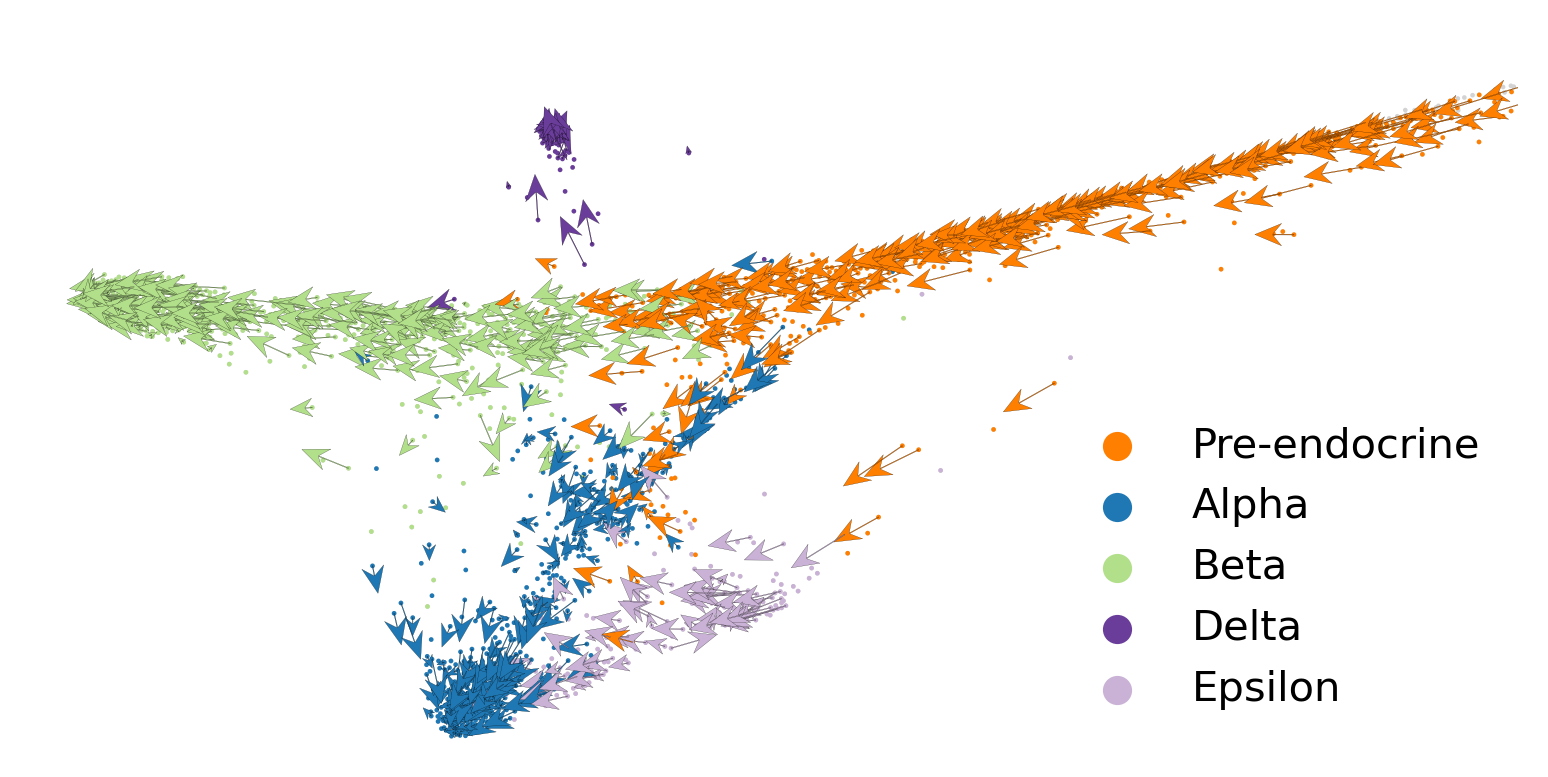

In [17]:
celltypes = ['Pre-endocrine', 'Alpha', 'Beta', 'Delta', 'Epsilon']

fig, ax = plt.subplots()
scv.pl.velocity_embedding(adata, basis='fa2', arrow_length=5, arrow_size=3, alpha=1, 
                          title='', density=0.4, size=5, legend_loc='best',
                          linewidth=0.05, show=False, ax=ax, groups=celltypes, 
                          xlim=[-8300, 0], ylim=[-3500, 500])
ax.set_aspect('equal')

## iPSCs reprogramming (RNA-seq)

The second half of this tutorial shows the analysis of cellular reprogramming. Cell reprogramming is a complex biological process aiming to convert cells to induced pluripotent stem cells (iPSC) before differentiation into diverse cell types.

The data comes from [Schiebinger, Geoffrey, et al. "Optimal-transport analysis of single-cell gene expression identifies developmental trajectories in reprogramming." Cell 176.4 (2019): 928-943.](https://www.sciencedirect.com/science/article/pii/S009286741930039X). The authors obtained Mouse Embryonic Fibroblasts (MEFs) from a single female embryo. They plated MEFs in serum, added Dox on day 0, withdrew Dox on day 8, and transferred cells to either serum-free N2B27 2i medium or maintained them in serum. Hence experiment can be split into Phase 1 (Dox) and Phase 2 (two separate conditions: 2i or serum). Phase 2 lasted till day 18. Here, we explore Phase 2's cells in serum condition, looking for the clear ancestor trajectory of day 18 iPSCs. Authors of the dataset found such a trajectory for cells in the 2i condition but not in the serum condition.

Load the necessary packages.

In [1]:
import anndata
from os.path import join
import pandas as pd
import scanpy as sc
import ocelli as oci
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300

SEED = 17

# a path to the folder with data
folder_path = '../../../../experiments/reprogramming/data'

### Load and preprocess the data

During data preparation, we ran the [Velocyto](http://velocyto.org) on [raw bam files](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE115943) (we run analyses on gene expression spliced layer). Then, we concatenated the resulting loom files into a single h5ad file and calculated doublet scores using [Scrublet](https://github.com/swolock/scrublet). 

Load the resulting h5ad file.

In [2]:
%%time

adata = anndata.read_h5ad(join(folder_path, 'reprogramming_doublet.h5ad'))

adata

CPU times: user 2.79 s, sys: 6.67 s, total: 9.46 s
Wall time: 9.45 s


AnnData object with n_obs × n_vars = 251203 × 27998
    obs: 'origin', 'barcode', 'velocyto_barcode', 'doublet_score', 'predicted_doublet'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

The whole dataset consists  of 251,203 cells and 27998 genes.

Clean up ``adata.obs``.

In [3]:
df_obs = pd.DataFrame(index=list(adata.obs.index))
df_obs['timestamp'] = [el.split('_')[0][1:] for el in adata.obs['origin']]
df_obs['origin'] = [el.split('_')[1] for el in adata.obs['origin']]
df_obs['doublet_score'] = list(adata.obs['doublet_score'])

adata.obs = df_obs

adata.obs

timestamp origin  doublet_score
D0.5_Dox_C2_AACGTTGAGTGGACGT-1          0.5    Dox       0.109677
D0.5_Dox_C2_AACTGGTGTAGAGTGC-1          0.5    Dox       0.179331
D0.5_Dox_C2_AAATGCCTCTCAAGTG-1          0.5    Dox       0.192308
D0.5_Dox_C2_AACTCCCAGTCAAGCG-1          0.5    Dox       0.103734
D0.5_Dox_C2_AACTTTCCATGTCGAT-1          0.5    Dox       0.286344
...                                     ...    ...            ...
DiPSC_serum_C2_TTTATGCCAGCTGTAT-1      iPSC  serum       0.126516
DiPSC_serum_C2_TTTCCTCCAAGAGTCG-1      iPSC  serum       0.121212
DiPSC_serum_C2_TTTCCTCGTTGGTTTG-1      iPSC  serum       0.121212
DiPSC_serum_C2_TTTGTCATCTTCGGTC-1      iPSC  serum       0.026253
DiPSC_serum_C2_TTTACTGTCACGATGT-1      iPSC  serum       0.215385

[251203 rows x 3 columns]

Load a gene list for ``adata.var``.

In [4]:
df_var = pd.read_csv(join(folder_path, 'var-genes.csv'), names=['gene'], index_col='gene', header=0)

adata.var = df_var

adata.var

Empty DataFrame
Columns: []
Index: [Xkr4, Gm37381, Rp1, Rp1-1, Sox17, Gm37323, Mrpl15, Rgs20, Npbwr1, 4732440D04Rik, Gm26901, Sntg1, Gm29520, Mybl1, Vcpip1, Snhg6, Tcf24, Ppp1r42, Cops5, Arfgef1, Cpa6, Gm29663, Slco5a1, Prdm14, Ncoa2, Tram1, Lactb2, Eya1, Msc, Trpa1, Sbspon, 4930444P10Rik, Rpl7, Stau2, Ube2w, Tceb1, Jph1, Gm28154, Gm16070, Gm28153, Crisp4, Defb18, Defb41, Gm15825, Pkhd1, Il17f, Mcm3, 6720483E21Rik, Tram2, Gm28836, Kcnq5, Rims1, 4933415F23Rik, Ogfrl1, Smap1, Sdhaf4, Fam135a, Col19a1, Gm28237, Gm29414, Adgrb3, 4931408C20Rik, Gm597, Gm9898, Phf3, Ptp4a1, Gm29669, 4931428L18Rik, Gm5415, Gm37591, Prim2, Bag2, Zfp451, Bend6, Gm37958, Gm37233, Ccdc115, Gm28306, 4930568A12Rik, Prss40, 1700101I19Rik, Gm38336, Fam168b, Gm37068, Gm37146, Gm33222, Gm37335, Uggt1, Neurl3, Kansl3, Lman2l, Gm38033, Ankrd23, Gm43543, Ankrd39, Sema4c, Fam178b, Actr1b, Gm33533, Tmem131, ...]

[27998 rows x 0 columns]

We focus on cells in serum condition.

In [5]:
adata = adata[adata.obs['origin'].isin(['Dox', 'serum']), :]

Remove cells with doublet score above 0.3. The doublet score histogram is plotten below.

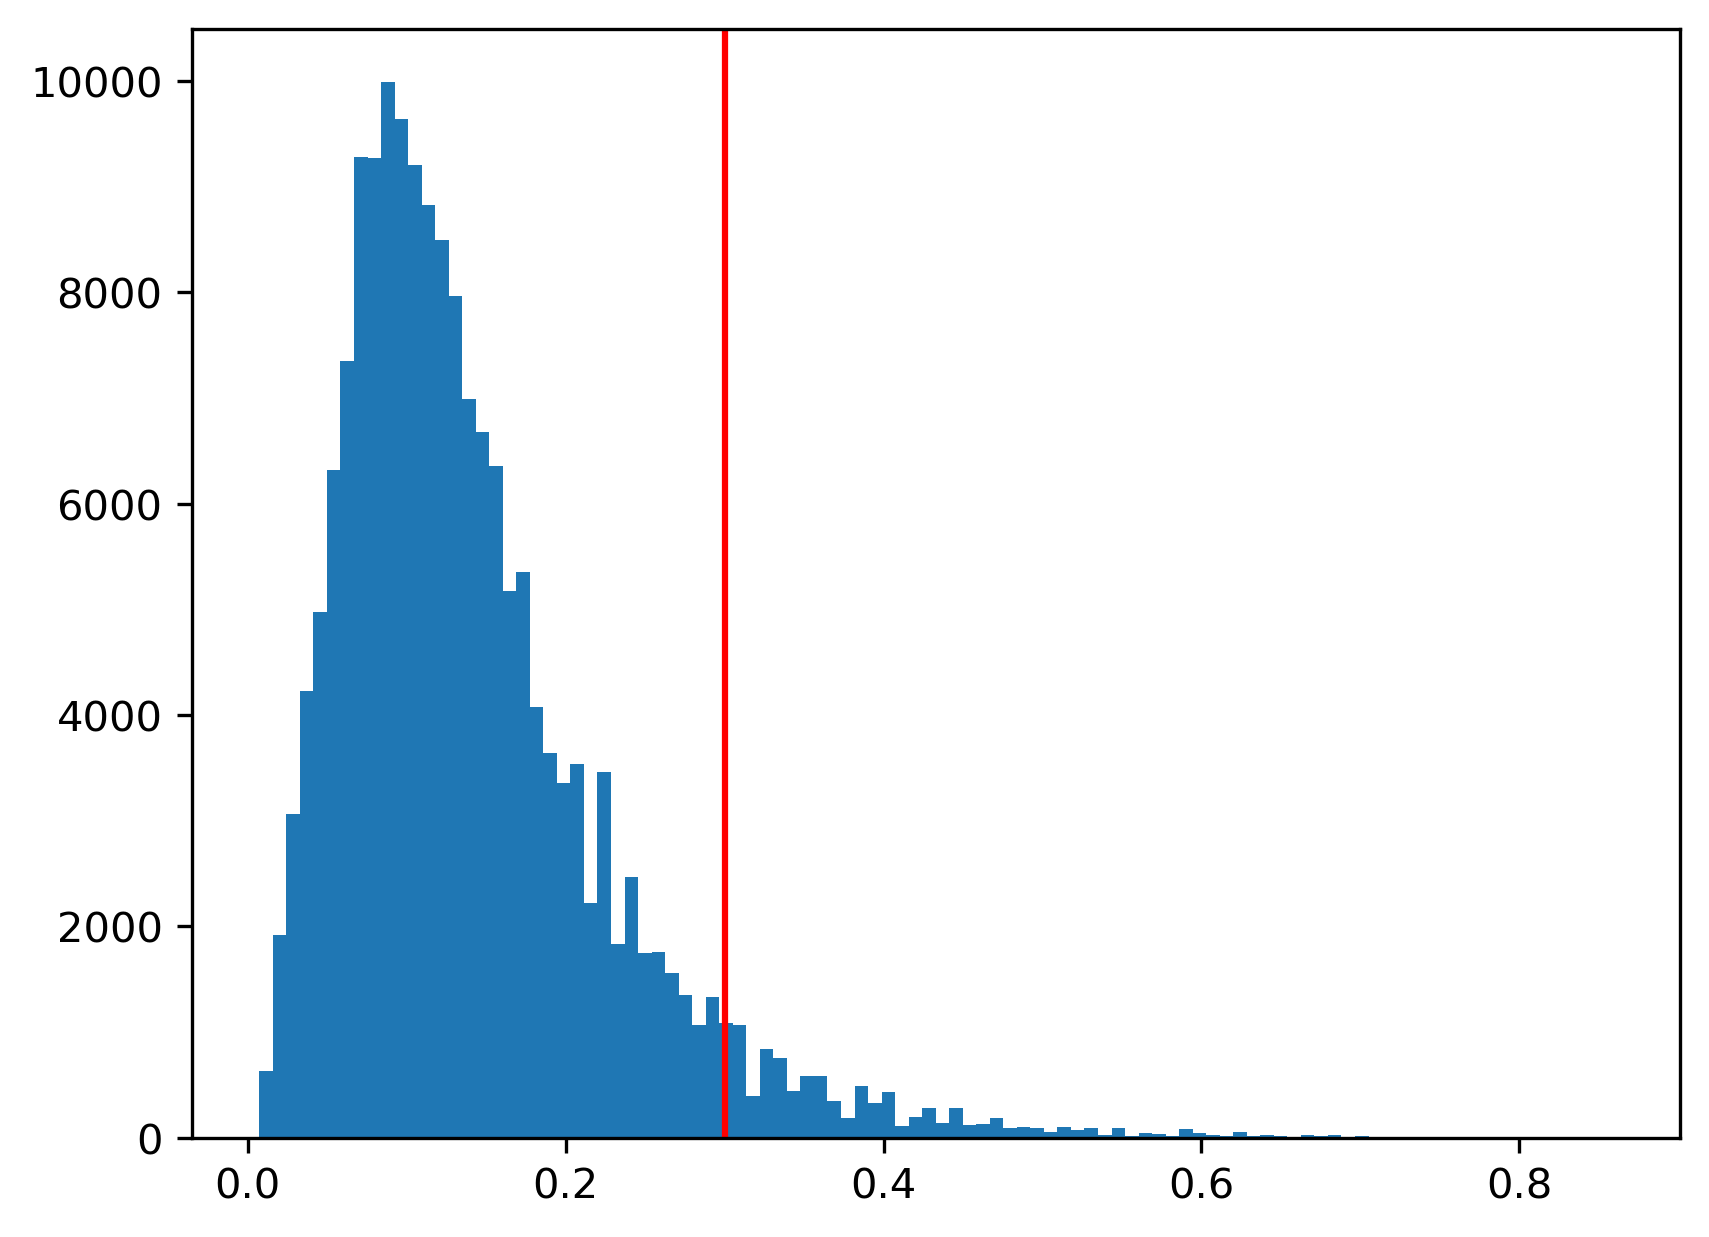

In [6]:
fig, ax = plt.subplots()
ax.hist(adata.obs['doublet_score'], 100)
ax.axvline(0.3, c='red')

adata = adata[adata.obs['doublet_score'] < 0.3]

Keep cells between days 8 and 18.

In [7]:
filtered_timestamps = ['8', '8.25', '8.5', '8.75', '9', '9.5',  
                       '10', '10.5', '11', '11.5', '12', '12.5',
                       '13', '13.5', '14', '14.5', '15', '15.5',
                       '16', '16.5', '17', '17.5', '18']

adata = adata[adata.obs['timestamp'].isin(filtered_timestamps), :]

adata.obs['timestamp_float'] = [float(t) for t in adata.obs['timestamp']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  


Preprocess the count matrix as the dataset authors:

- remove cells with less than 2000 UMIs,
- remove genes expressed in less than 50 cells,
- if cell's UMI count is greater than 15,000, donwsample it to 15,000 UMIs.

In [8]:
sc.pp.filter_cells(adata, min_counts=2000)
sc.pp.filter_genes(adata, min_cells=50)
sc.pp.downsample_counts(adata, counts_per_cell=15000, random_state=SEED)

The filtered AnnData consists of 68703 cells and 16817 genes.

In [9]:
adata

AnnData object with n_obs × n_vars = 68703 × 16817
    obs: 'timestamp', 'origin', 'doublet_score', 'timestamp_float', 'n_counts'
    var: 'n_cells'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

Generate topic-based modalities.

In [10]:
oci.pp.LDA(adata, n_components=20, output_key='lda', verbose=1, max_iter=30, random_state=SEED)
oci.pp.modality_generation(adata, topic_key='lda', norm_log=True, verbose=True)

iteration: 1 of max_iter: 30
iteration: 2 of max_iter: 30
iteration: 3 of max_iter: 30
iteration: 4 of max_iter: 30
iteration: 5 of max_iter: 30
iteration: 6 of max_iter: 30
iteration: 7 of max_iter: 30
iteration: 8 of max_iter: 30
iteration: 9 of max_iter: 30
iteration: 10 of max_iter: 30
iteration: 11 of max_iter: 30
iteration: 12 of max_iter: 30
iteration: 13 of max_iter: 30
iteration: 14 of max_iter: 30
iteration: 15 of max_iter: 30
iteration: 16 of max_iter: 30
iteration: 17 of max_iter: 30
iteration: 18 of max_iter: 30
iteration: 19 of max_iter: 30
iteration: 20 of max_iter: 30
iteration: 21 of max_iter: 30
iteration: 22 of max_iter: 30
iteration: 23 of max_iter: 30
iteration: 24 of max_iter: 30
iteration: 25 of max_iter: 30
iteration: 26 of max_iter: 30
iteration: 27 of max_iter: 30
iteration: 28 of max_iter: 30
iteration: 29 of max_iter: 30
iteration: 30 of max_iter: 30
[modality0]	Modality generated.
[modality1]	Modality generated.
[modality2]	Modality generated.


/opt/conda/lib/python3.7/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


[modality3]	Modality generated.
[modality4]	Modality generated.
[modality5]	Modality generated.
[modality6]	Modality generated.
[modality7]	Modality generated.
[modality8]	Modality generated.
[modality9]	Modality generated.
[modality10]	Modality generated.
[modality11]	Modality generated.
[modality12]	Modality generated.
[modality13]	Modality generated.
[modality14]	Modality generated.
[modality15]	Modality generated.
[modality16]	Modality generated.
[modality17]	Modality generated.
[modality18]	Modality generated.
[modality19]	Modality generated.
20 topic-based modalities generated.


### Waddington Optimal Transport

Ocelli can use cellular transition probabilities calculated using any algorithm. Here, we use [Waddington Optimal Transport](https://www.sciencedirect.com/science/article/pii/S009286741930039X) precomputed transitions, which you can download [here](https://broadinstitute.github.io/wot/tutorial/) from the *transport maps* tutorial. The tutorial contains h5ad files with transitions between consecutive timestamps. In the code below we combine all transitions into a single csr_matrix and save it in ``adata.uns['optimal_transport']``.

In [11]:
import numpy as np
from scipy.sparse import coo_matrix
from tqdm import tqdm

# clear adata.X and adata.layers co that adata object uses less memory
# modalities are already saved in adata.obsm
adata.X = csr_matrix(([], ([], [])), shape=adata.shape)
adata.layers = {}

paths = ['serum_8.0_8.25.h5ad', 'serum_8.25_8.5.h5ad',  'serum_8.5_8.75.h5ad', 
         'serum_8.75_9.0.h5ad', 'serum_9.0_9.5.h5ad', 'serum_9.5_10.0.h5ad', 
         'serum_10.0_10.5.h5ad', 'serum_10.5_11.0.h5ad', 'serum_11.0_11.5.h5ad', 
         'serum_11.5_12.0.h5ad', 'serum_12.0_12.5.h5ad', 'serum_12.5_13.0.h5ad', 
         'serum_13.0_13.5.h5ad', 'serum_13.5_14.0.h5ad', 'serum_14.0_14.5.h5ad', 
         'serum_14.5_15.0.h5ad', 'serum_15.0_15.5.h5ad', 'serum_15.5_16.0.h5ad', 
         'serum_16.0_16.5.h5ad', 'serum_16.5_17.0.h5ad', 'serum_17.0_17.5.h5ad', 
         'serum_17.5_18.0.h5ad']

def filter_cells(adata, x):
    obs_in, var_in = list(), list()
    
    for el in adata.obs.index:
        if el in x.obs.index:
            obs_in.append(el)
    for el in adata.obs.index:
        if el in x.var.index:
            var_in.append(el)
            
    return x[obs_in, var_in]
        
barcode_map = dict()
for i, barcode in enumerate(adata.obs.index):
    barcode_map[barcode] = i
    
M = coo_matrix(([], ([], [])), shape=(adata.shape[0], adata.shape[0])).tocsr()
    
for path in tqdm(paths):
    x = anndata.read_h5ad(join(folder_path, 'tmaps/{}'.format(path)))    
    x = filter_cells(adata, x)
    
    obs = [barcode_map[el] for el in x.obs.index]
    var = [barcode_map[el] for el in x.var.index]
    
    M[np.ix_(obs, var)] = csr_matrix(x.X)

adata.uns['optimal_transport'] = M

  0%|          | 0/22 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/scipy/sparse/_index.py:116: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|██████████| 22/22 [02:21<00:00,  6.42s/it]


### Multimodal Diffusion Maps

Calculate the MDM components using LDA-based weights.

In [12]:
oci.pp.neighbors(adata, n_neighbors=20, verbose=True)
oci.tl.MDM(adata, weights_key='lda_weights', n_components=20, random_state=SEED, verbose=True, save_mmc=True)

[modality0]	20 nearest neighbors calculated.
[modality1]	20 nearest neighbors calculated.
[modality2]	20 nearest neighbors calculated.
[modality3]	20 nearest neighbors calculated.
[modality4]	20 nearest neighbors calculated.
[modality5]	20 nearest neighbors calculated.
[modality6]	20 nearest neighbors calculated.
[modality7]	20 nearest neighbors calculated.
[modality8]	20 nearest neighbors calculated.
[modality9]	20 nearest neighbors calculated.
[modality10]	20 nearest neighbors calculated.
[modality11]	20 nearest neighbors calculated.
[modality12]	20 nearest neighbors calculated.
[modality13]	20 nearest neighbors calculated.
[modality14]	20 nearest neighbors calculated.
[modality15]	20 nearest neighbors calculated.
[modality16]	20 nearest neighbors calculated.
[modality17]	20 nearest neighbors calculated.
[modality18]	20 nearest neighbors calculated.
[modality19]	20 nearest neighbors calculated.


2022-11-03 00:51:38,012	INFO worker.py:1518 -- Started a local Ray instance.


[modality0]	Unimodal Markov chain calculated.
[modality1]	Unimodal Markov chain calculated.
[modality2]	Unimodal Markov chain calculated.
[modality3]	Unimodal Markov chain calculated.
[modality4]	Unimodal Markov chain calculated.
[modality5]	Unimodal Markov chain calculated.
[modality6]	Unimodal Markov chain calculated.
[modality7]	Unimodal Markov chain calculated.
[modality8]	Unimodal Markov chain calculated.
[modality9]	Unimodal Markov chain calculated.
[modality10]	Unimodal Markov chain calculated.
[modality11]	Unimodal Markov chain calculated.
[modality12]	Unimodal Markov chain calculated.
[modality13]	Unimodal Markov chain calculated.
[modality14]	Unimodal Markov chain calculated.
[modality15]	Unimodal Markov chain calculated.
[modality16]	Unimodal Markov chain calculated.
[modality17]	Unimodal Markov chain calculated.
[modality18]	Unimodal Markov chain calculated.
[modality19]	Unimodal Markov chain calculated.
Multimodal Markov chain calculated.
Eigendecomposition finished.
20 Mu

Generate a 3D ForceAtlas2 embedding. ``oci.tl.timestamp_graph`` produces a graph similar to ``oci.tl.velocity_graph``, but uses additional information from timestamps. You can find details in the API.

In [13]:
oci.pp.neighbors(adata, modalities=['X_mdm'], n_neighbors=100, verbose=True)
oci.tl.timestamp_graph(adata, 
                       transitions_key='optimal_transport', 
                       timestamps_key='timestamp_float', 
                       n_edges=10,
                       neighbors_key='X_mdm', 
                       verbose=True)

oci.tl.FA2(adata, n_components=3, n_iter=15000, random_state=SEED, output_key='X_fa2')

[X_mdm]	100 nearest neighbors calculated.


23it [01:02,  2.70s/it]


Timestamp-based graph constructed.


Nov 03, 2022 12:56:42 AM org.netbeans.modules.masterfs.watcher.Watcher getNotifierForPlatform
INFO: Native file watcher is disabled
Nov 03, 2022 12:56:45 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Nodes loaded: 68,703 (68,703 added)
Nov 03, 2022 12:56:45 AM org.gephi.io.processor.plugin.DefaultProcessor process
INFO: # Edges loaded: 687,030 (607,494 added)


*

************************25%
*************************50%
*************************75%
*************************100%
Time = 1431.718s


To create an interactive 3D scatter plot in html, use the code below. Generated plot is available for download [here](https://github.com/TabakaLab/ocelli/tree/dev/html/ipsc_reprogramming).

In [14]:
plot = oci.pl.scatter(adata, x_key='X_fa2', color_key='timestamp_float', marker_size=1, method='plotly', cmap='viridis')
plot.write_html(join(folder_path, 'Timestamps.html'))

To generate 2D projection plots, run the following.

(<Figure size 1920x1440 with 16 Axes>,
 array([[<AxesSubplot:title={'center':'alpha=0 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=0 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=0 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=0 beta=135'}>],
        [<AxesSubplot:title={'center':'alpha=45 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=45 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=45 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=45 beta=135'}>],
        [<AxesSubplot:title={'center':'alpha=90 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=90 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=90 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=90 beta=135'}>],
        [<AxesSubplot:title={'center':'alpha=135 beta=0'}>,
         <AxesSubplot:title={'center':'alpha=135 beta=45'}>,
         <AxesSubplot:title={'center':'alpha=135 beta=90'}>,
         <AxesSubplot:title={'center':'alpha=135 beta=135'}>

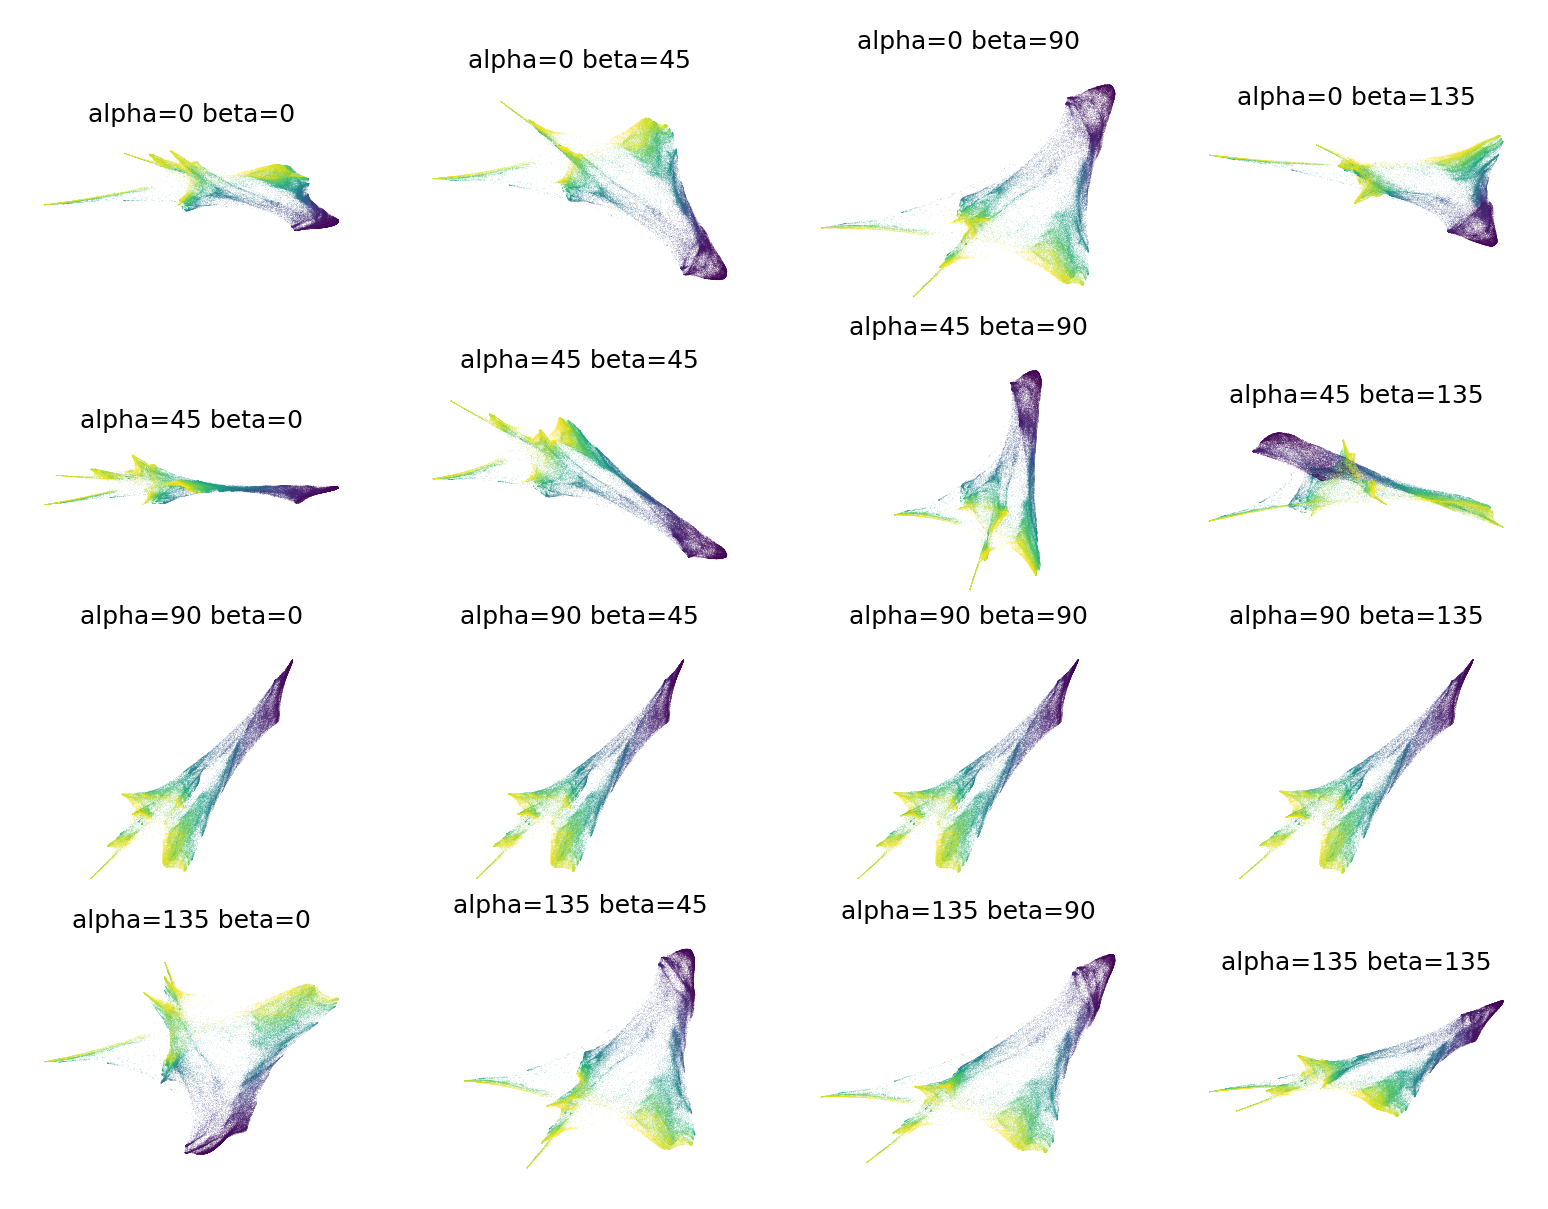

In [15]:
oci.pl.perspectives(adata, x_key='X_fa2', color_key='timestamp_float', marker_size=0.01, cmap='viridis')

MDM successfully reconstructed a clear ancestor trajectory of day 18 iPSCs for cells in serum condition. This is a thin string connecting day 18 iPSCs and day 10 cells, coming out of the spike on the left side of the plot. The biology behind this string is described [here](https://www.sciencedirect.com/science/article/pii/S009286741930039X).

(<Figure size 1920x1440 with 2 Axes>,
 <AxesSubplot:title={'center':'timestamp_float'}>)

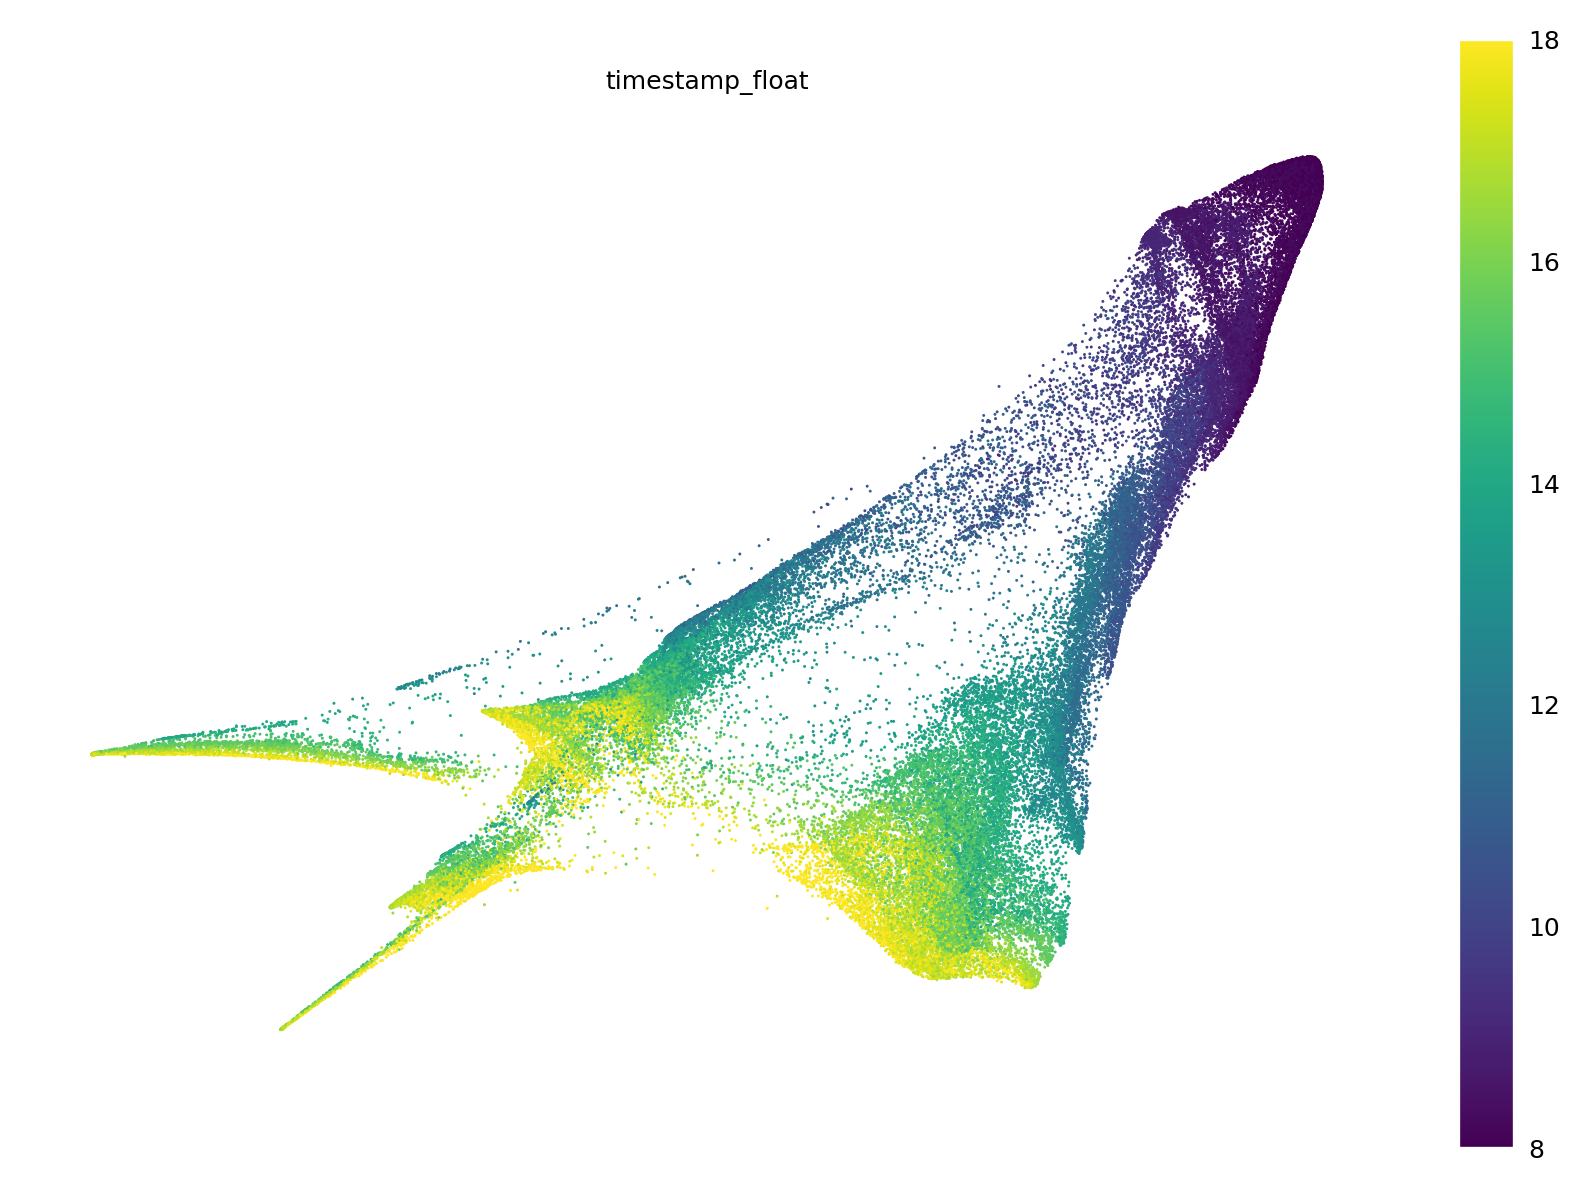

In [16]:
oci.tl.project_2d(adata, x_key='X_fa2', output_key='X_proj', alpha=135, beta=90, random_state=SEED)
oci.pl.scatter(adata, x_key='X_proj', color_key='timestamp_float', cmap='viridis', marker_size=0.5)

Finally, investigate the topic quality.

(<Figure size 1920x1440 with 40 Axes>,
 array([[<AxesSubplot:title={'center':'0'}>,
         <AxesSubplot:title={'center':'1'}>,
         <AxesSubplot:title={'center':'2'}>,
         <AxesSubplot:title={'center':'3'}>],
        [<AxesSubplot:title={'center':'4'}>,
         <AxesSubplot:title={'center':'5'}>,
         <AxesSubplot:title={'center':'6'}>,
         <AxesSubplot:title={'center':'7'}>],
        [<AxesSubplot:title={'center':'8'}>,
         <AxesSubplot:title={'center':'9'}>,
         <AxesSubplot:title={'center':'10'}>,
         <AxesSubplot:title={'center':'11'}>],
        [<AxesSubplot:title={'center':'12'}>,
         <AxesSubplot:title={'center':'13'}>,
         <AxesSubplot:title={'center':'14'}>,
         <AxesSubplot:title={'center':'15'}>],
        [<AxesSubplot:title={'center':'16'}>,
         <AxesSubplot:title={'center':'17'}>,
         <AxesSubplot:title={'center':'18'}>,
         <AxesSubplot:title={'center':'19'}>]], dtype=object))

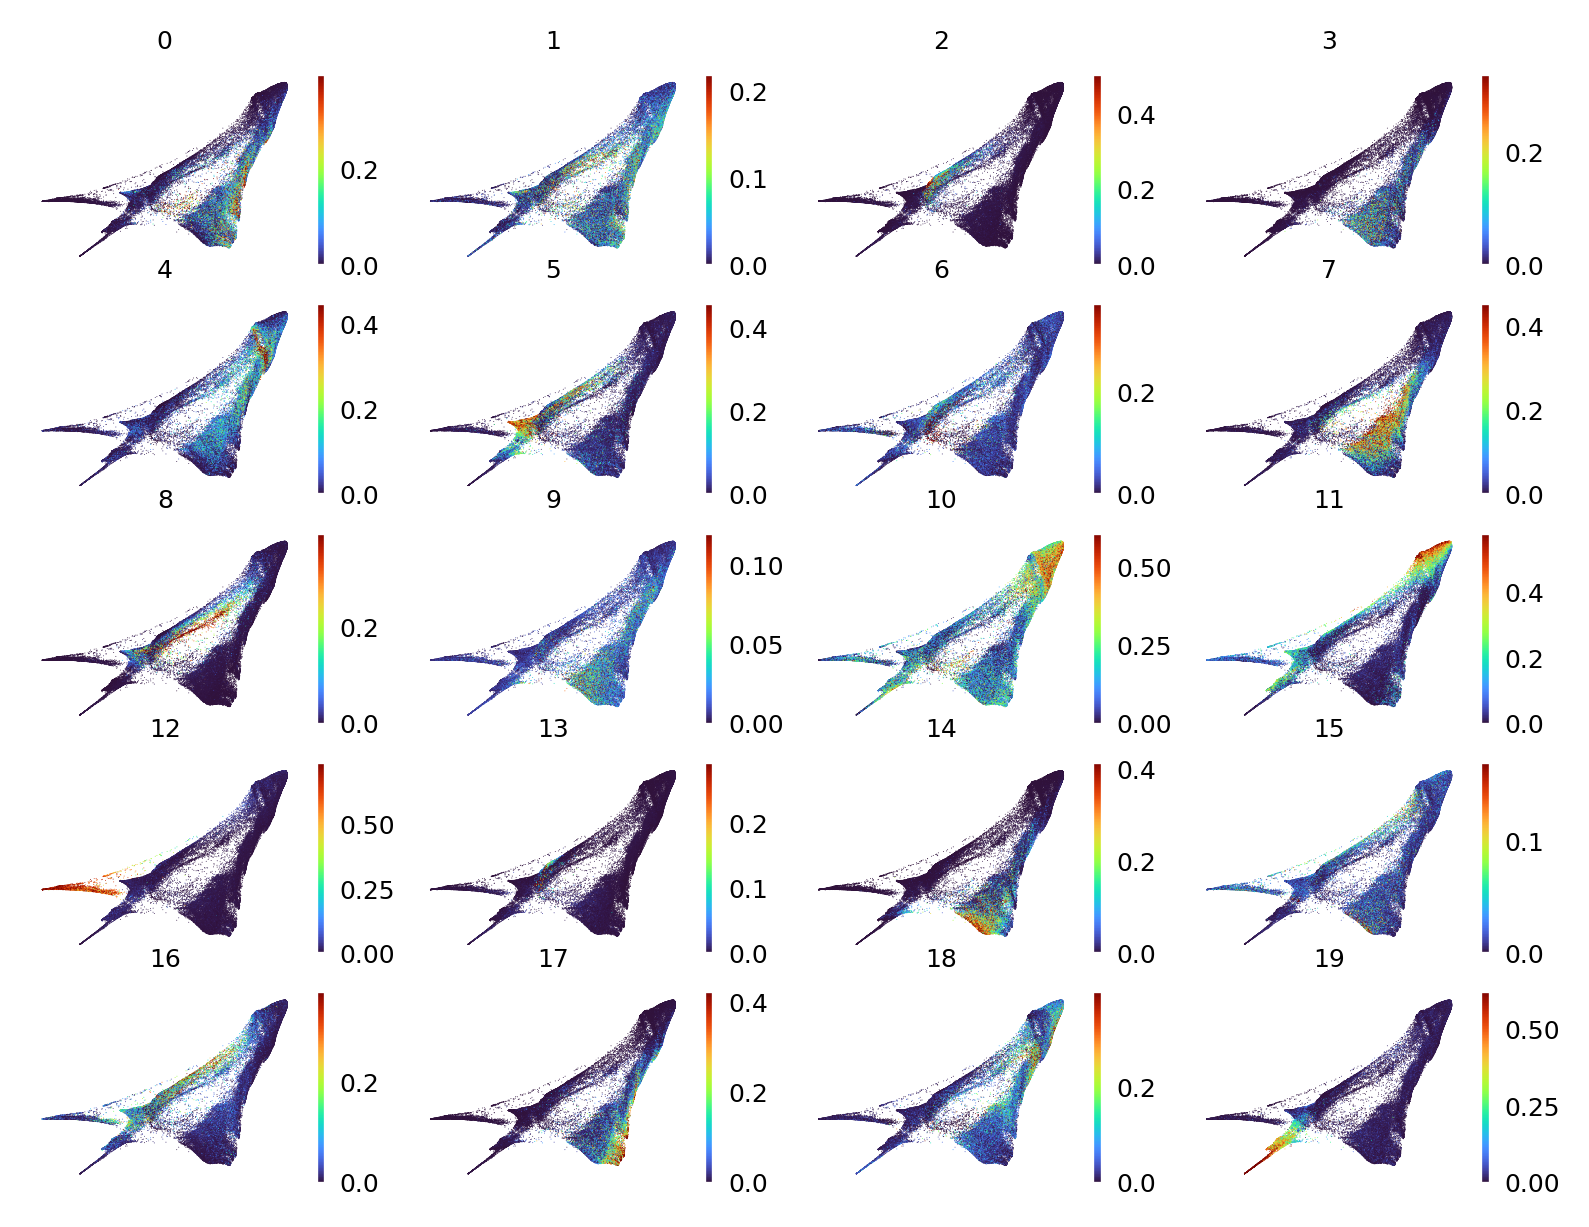

In [17]:
oci.pl.scatter(adata, x_key='X_proj', color_key='lda', cmap='turbo', marker_size=0.05, vmin=0, max_columns=4)

Congratulations! Now you can easily use Ocelli for your single-cell analyses. Good luck!